In [57]:
import numpy as np 
import pandas as pd 

In [58]:
import matplotlib.pyplot as plt
import os

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from string import punctuation

import re

In [59]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [60]:
data = pd.read_csv('https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/amazon.csv')
data.columns

Index(['reviewText', 'Positive'], dtype='object')

In [61]:
data.head()

,reviewText,Positive
0,This is a one of the best apps acording to a b...,1
1,This is a pretty good version of the game for ...,1
2,this is a really cool game. there are a bunch ...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1


In [62]:
data.Positive.value_counts()

1    15233
0     4767
Name: Positive, dtype: int64

In [63]:
data1 = data.copy()
data1.columns = ["Comment", "Label"]
data1.head()

,Comment,Label
0,This is a one of the best apps acording to a b...,1
1,This is a pretty good version of the game for ...,1
2,this is a really cool game. there are a bunch ...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1


* **Data transformation**

In [64]:
stop_words=set(stopwords.words('english'))
lzr = WordNetLemmatizer()

In [65]:
def text_processing(text):   
    # convert text into lowercase
    text = text.lower()

    # remove new line characters in text
    text = re.sub(r'\n',' ', text)
    
    # remove punctuations from text
    text = re.sub('[%s]' % re.escape(punctuation), "", text)
    
    # remove references and hashtags from text
    text = re.sub("^a-zA-Z0-9$,.", "", text)
    
    # remove multiple spaces from text
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # remove special characters from text
    text = re.sub(r'\W', ' ', text)

    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    
    text=' '.join([lzr.lemmatize(word) for word in word_tokenize(text)])

    return text

In [66]:
nltk.download('omw-1.4')
data_copy = data1.copy()
data_copy.Comment = data_copy.Comment.apply(text_processing)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [67]:
#difference_counts = (data_copy["Label"] == 1).sum() - (data_copy["Label"] == 0).sum()
data_copy["Label"].value_counts()

1    15233
0     4767
Name: Label, dtype: int64

In [68]:
from sklearn.utils import resample
    
df_negative = data_copy[(data_copy['Label']==0)]
df_positive = data_copy[(data_copy['Label']==1)]

# upsample minority classes
df_negative_upsampled = resample(df_negative, 
                                 replace=True,    
                                 n_samples=15233, 
                                 random_state=15)  



#  Concatenate the upsampled dataframes
data_copy = pd.concat([df_negative_upsampled,df_positive])

data_copy['Label'].value_counts()

0    15233
1    15233
Name: Label, dtype: int64

In [69]:
sentiments = SentimentIntensityAnalyzer()
data_copy["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data_copy["Comment"]]
data_copy["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data_copy["Comment"]]
data_copy["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data_copy["Comment"]]
data_copy['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in data_copy["Comment"]]
score = data_copy["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
data_copy["VaderSentiment"] = sentiment

In [84]:
data_copy

,Comment,Label,Positive,Negative,Neutral,Compound,VaderSentiment
17642,app look cool founded installing fire look dul...,0,0.194,0.279,0.527,-0.3071,0
11827,could never get work correctly tried several m...,0,0.239,0.000,0.761,0.2815,2
9512,doesnt said doesnt list apps fire im disappoin...,0,0.144,0.219,0.637,-0.2649,0
12174,bad truned volume way could not60when cant hea...,0,0.000,0.390,0.610,-0.7506,0
14866,stupid ap beginning beat girl cheat one minute...,0,0.000,0.348,0.652,-0.7506,0
...,...,...,...,...,...,...,...
19992,love app cant get enough almost like green far...,1,0.368,0.000,0.632,0.7512,2
19993,could rate 1000000000000000000000 star honestl...,1,0.549,0.000,0.451,0.9274,2
19996,please add need neighbor ginger1016 thanks bun...,1,0.602,0.000,0.398,0.9337,2
19997,love game awesome wish free stuff house didnt ...,1,0.556,0.210,0.233,0.8719,2


* **Final data**

In [85]:
data2=data_copy.drop(['Positive','Negative','Neutral','Compound'],axis=1)
data2.head()

,Comment,Label,VaderSentiment
17642,app look cool founded installing fire look dul...,0,0
11827,could never get work correctly tried several m...,0,2
9512,doesnt said doesnt list apps fire im disappoin...,0,0
12174,bad truned volume way could not60when cant hea...,0,0
14866,stupid ap beginning beat girl cheat one minute...,0,0


In [86]:
data2['VaderSentiment'].value_counts()

2    21056
0     7592
1     1818
Name: VaderSentiment, dtype: int64

In [87]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_copy['VaderSentiment'] = le.fit_transform(data2['VaderSentiment'])

In [88]:
data_copy['VaderSentiment'].value_counts()

2    21056
0     7592
1     1818
Name: VaderSentiment, dtype: int64

In [101]:
data_copy.head()

,Comment,Label,Positive,Negative,Neutral,Compound,VaderSentiment
17642,app look cool founded installing fire look dul...,0,0.194,0.279,0.527,-0.3071,0
11827,could never get work correctly tried several m...,0,0.239,0.000,0.761,0.2815,2
9512,doesnt said doesnt list apps fire im disappoin...,0,0.144,0.219,0.637,-0.2649,0
12174,bad truned volume way could not60when cant hea...,0,0.000,0.390,0.610,-0.7506,0
14866,stupid ap beginning beat girl cheat one minute...,0,0.000,0.348,0.652,-0.7506,0


In [102]:
processed_data = {
    'Sentence':data_copy.Comment,
    'Label': data_copy.Label,
    'VaderSentiment':data_copy['VaderSentiment']
}

processed_data = pd.DataFrame(processed_data)
processed_data

,Sentence,Label,VaderSentiment
17642,app look cool founded installing fire look dul...,0,0
11827,could never get work correctly tried several m...,0,2
9512,doesnt said doesnt list apps fire im disappoin...,0,0
12174,bad truned volume way could not60when cant hea...,0,0
14866,stupid ap beginning beat girl cheat one minute...,0,0
...,...,...,...
19992,love app cant get enough almost like green far...,1,2
19993,could rate 1000000000000000000000 star honestl...,1,2
19996,please add need neighbor ginger1016 thanks bun...,1,2
19997,love game awesome wish free stuff house didnt ...,1,2


In [103]:
processed_data['VaderSentiment'].value_counts()

2    21056
0     7592
1     1818
Name: VaderSentiment, dtype: int64

In [104]:
from sklearn.utils import resample
    
df_negative = processed_data[(processed_data['VaderSentiment']==0)]
df_neutral = processed_data[(processed_data['VaderSentiment']==1)]
df_positive = processed_data[(processed_data['VaderSentiment']==2)]

# upsample minority classes
df_negative_upsampled = resample(df_negative, 
                                 replace=True,    
                                 n_samples=20990, 
                                 random_state=12)

df_neutral_upsampled = resample(df_neutral, 
                                 replace=True,    
                                 n_samples=20990, 
                                 random_state=19)  



#  Concatenate the upsampled dataframes
processed_data = pd.concat([df_negative_upsampled,df_neutral_upsampled,df_positive])

processed_data['VaderSentiment'].value_counts()

2    21056
0    20990
1    20990
Name: VaderSentiment, dtype: int64

In [105]:
processed_data

,Sentence,Label,VaderSentiment
2251,doesnt work kindlememory storage large enoughs...,0,0
16525,kindle arrow dont work u cant even playif u ki...,0,0
18620,game unplayable price control horrible lag cra...,0,0
863,heard game tried see liked found puzzle hard w...,0,0
15730,finally figured pause button stopped darn pian...,1,0
...,...,...,...
19992,love app cant get enough almost like green far...,1,2
19993,could rate 1000000000000000000000 star honestl...,1,2
19996,please add need neighbor ginger1016 thanks bun...,1,2
19997,love game awesome wish free stuff house didnt ...,1,2


In [106]:
final_data = processed_data.copy()

In [107]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(final_data['Label'], final_data['VaderSentiment']))

[[17930 15570  7400]
 [ 3060  5420 13656]
 [    0     0     0]]


In [108]:
from sklearn.metrics import classification_report
print(classification_report(final_data['Label'], final_data['VaderSentiment']))

              precision    recall  f1-score   support

           0       0.85      0.44      0.58     40900
           1       0.26      0.24      0.25     22136
           2       0.00      0.00      0.00         0

    accuracy                           0.37     63036
   macro avg       0.37      0.23      0.28     63036
weighted avg       0.64      0.37      0.46     63036



C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Naive Bayes Model

In [110]:
corpus = []
for sentence in final_data['Sentence']:
    corpus.append(sentence)
corpus[0:5]

['doesnt work kindlememory storage large enoughshould bold letter purchasewasted money unhappy',
 'kindle arrow dont work u cant even playif u kindle firei dont recommend',
 'game unplayable price control horrible lag crash constantly also huge 15mb sheesh lead believe unoptimized badly programmed could explain insane',
 'heard game tried see liked found puzzle hard wasted ridiculous amount time attempting solve deleted game tablet',
 'finally figured pause button stopped darn piano left sound effect going became worth 5 starsim going try real sleep tonight since house noisy im really bothered sound']

In [111]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(corpus).toarray()
y = final_data["VaderSentiment"].values

## Machine Learning Model 

In [112]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

* **Evaluation**

In [113]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[3095, 2751,  391],
       [ 152, 5985,  183],
       [1107, 2995, 2252]], dtype=int64)

In [114]:
nb_score = accuracy_score(y_test, y_pred)
print('accuracy',nb_score)

accuracy 0.5992279625614721


In [115]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.50      0.58      6237
           1       0.51      0.95      0.66      6320
           2       0.80      0.35      0.49      6354

    accuracy                           0.60     18911
   macro avg       0.67      0.60      0.58     18911
weighted avg       0.67      0.60      0.58     18911



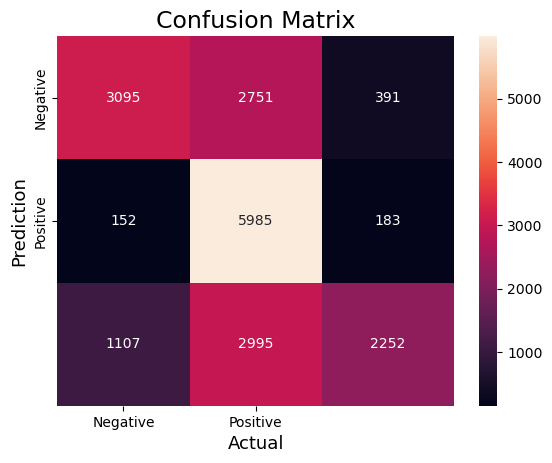

In [116]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Negative','Positive'],
            yticklabels=['Negative','Positive'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()